### Interactive Recommendation System with Word Embeddings using Word2Vec, Plotly, and NetworkX

### Project Breakdown
- Exploratory Data Analysis and Preprocessing
- Word2Vec with Gensim
- Exploring Results
- Building and Visualizing Interactive Network Graph

### Exploratory Data Analysis and Preprocessing

In [559]:
from gensim.parsing.preprocessing import remove_stopwords
from tqdm import tqdm
import pandas as pd
import pickle
import string
import json
import os
from tqdm import tqdm

In [281]:
train_data_path = 'aclImdb/train/'
file_path_list = []
# Get all file paths
for root, dirs, files in os.walk(train_data_path):
    for file in files:
        if file.endswith('.txt'):
            file_path_list.append(os.path.join(root, file))

In [282]:
len(file_path_list)

75000

In [317]:
# custom stopwords
to_remove = [
    '\n',
    'br',
    'thats', 
    'that',
    'they',
    'so'
]

translation_table = str.maketrans('', '', string.punctuation.replace("-", "")+string.digits) # remove punctuation and digits

In [298]:
remove_stopwords(remove_stopwords('this is a then thats test \n <br />'))

'thats test <br />'

In [324]:
# Read all files and create a list of lists
all_reviews = []
i = 0
for file_path in tqdm(file_path_list):
    with open(file_path, 'r', encoding='utf-8') as f:
        review = f.read()
        # Remove stopwords
        review = remove_stopwords(review)
        # Remove punctuation
        review = review.translate(translation_table)
        # Convert to lowercase
        review = review.lower()
        # Remove custom stopwords
        for stop_word in to_remove:
            review = review.replace(stop_word, '')
        # Split into words
        review = review.split()
        all_reviews.append(review)

100%|██████████| 75000/75000 [00:20<00:00, 3710.70it/s]


In [325]:
len(all_reviews), len(all_reviews[0]), len(all_reviews[1])

(75000, 64, 421)

In [326]:
all_reviews[-100]

['after',
 'looking',
 'comments',
 'awful',
 'slasher',
 'i',
 'opinion',
 'totally',
 'wrong',
 'this',
 'gore',
 'need',
 'maybe',
 'more',
 'bloody',
 'edge',
 'effects',
 'wernt',
 'terrible',
 'end',
 'woman',
 'grabbed',
 'hair',
 'shes',
 'hanging',
 'lighhouse',
 'look',
 'little',
 'bit',
 'stupid',
 'this',
 'actually',
 'average',
 'acting',
 'characters',
 'arnt',
 'wooden',
 'actors',
 'but',
 'b-movie',
 'proudly',
 'its',
 'way',
 'slashers',
 'id',
 'the',
 'lighthouse',
 '-',
 'god',
 'bless',
 'itish',
 'horrornow',
 'watch',
 'cradle',
 'of',
 'fear',
 'ultimate',
 'cheese',
 'awful',
 'acting',
 'terrible',
 'dialogue',
 'horror',
 'fan',
 'like',
 'me']

In [558]:
with open('Data/all_reviews.pkl', 'wb') as f:
    pickle.dump(all_reviews, f)

### Word2Vec

In [560]:
import gensim
from gensim.models.word2vec import Word2Vec

In [561]:
with open('Data/all_reviews.pkl', 'rb') as f:
    all_reviews = pickle.load(f)

In [563]:
model = Word2Vec(sg=0) #
model.build_vocab(all_reviews) # build vocabulary
model.wv.key_to_index.__len__() # number of unique words

52403

In [565]:
model.train(all_reviews, total_examples=model.corpus_count, epochs=10, report_delay=1.0, compute_loss=True)

(83606910, 91732850)

In [337]:
gensim.models.word2vec.Word2Vec.get_latest_training_loss(model)

23494170.0

In [596]:
# model.wv.most_similar(positive=['king', 'queen'], negative=['man'], topn=10)
# Analogy test
model.wv.evaluate_word_analogies('Data/google_analogies_small.txt')

(0.5384615384615384,
 [{'section': 'family',
   'correct': [('UNCLE', 'AUNT', 'BOY', 'GIRL')],
   'incorrect': [('PRINCE', 'PRINCESS', 'KING', 'QUEEN')]},
  {'section': 'gram',
   'correct': [('GOOD', 'BEST', 'STRANGE', 'STRANGEST'),
    ('SLOW', 'SLOWING', 'JUMP', 'JUMPING'),
    ('BANANA', 'BANANAS', 'COMPUTER', 'COMPUTERS'),
    ('EYE', 'EYES', 'CHILD', 'CHILDREN'),
    ('TALK', 'TALKS', 'PLAY', 'PLAYS'),
    ('WRITE', 'WRITES', 'GO', 'GOES')],
   'incorrect': [('POSSIBLE', 'IMPOSSIBLE', 'EFFICIENT', 'INEFFICIENT'),
    ('OLD', 'OLDER', 'CHEAP', 'CHEAPER'),
    ('EGYPT', 'EGYPTIAN', 'INDIA', 'INDIAN'),
    ('DECREASING', 'DECREASED', 'INCREASING', 'INCREASED'),
    ('FIND', 'FINDS', 'IMPLEMENT', 'IMPLEMENTS')]},
  {'section': 'Total accuracy',
   'correct': [('UNCLE', 'AUNT', 'BOY', 'GIRL'),
    ('GOOD', 'BEST', 'STRANGE', 'STRANGEST'),
    ('SLOW', 'SLOWING', 'JUMP', 'JUMPING'),
    ('BANANA', 'BANANAS', 'COMPUTER', 'COMPUTERS'),
    ('EYE', 'EYES', 'CHILD', 'CHILDREN'),
    ('TALK

In [ ]:
# analogy test
egg = model.wv['egg']
eggs = model.wv['eggs']
pretzel = model.wv['pretzel']
print(model.wv.most_similar(positive=[eggs, pretzel], negative=[egg], topn=1))

In [168]:
model.save('Data/w2v_movie_reviews.model')

### Exploring Results

In [552]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import random
random.seed(3)

In [553]:
model = Word2Vec.load('Data/w2v_movie_reviews.model')
model.wv.key_to_index.__len__() # Number of words in the vocabulary

52178

In [554]:
test_words = ['king',
    'queen',
    'man',
    'woman',
    'dog',
    'cat',
    'apple',
    'orange',
    'happy',
    'sad',
    'big',
    'small',
    'fast',
    'slow',
    'love'
]

In [555]:
words, vectors = [], []
for word in test_words:
    try:
        vectors.append(model.wv.get_vector(word))
        words.append(word)
    except KeyError:
        print(f'Word {word} not found in vocab!')        

In [556]:
sims = cosine_similarity(vectors, vectors)
sims.shape

(15, 15)

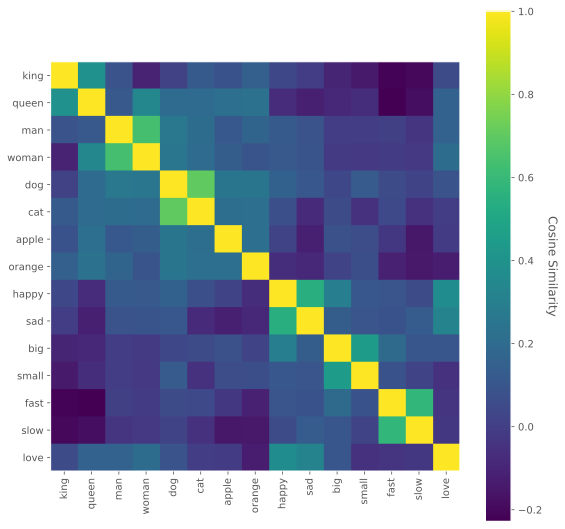

In [557]:
# adapted from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
im = ax.imshow(sims)

ax.set_xticks(np.arange(len(words)))
ax.set_yticks(np.arange(len(words)))

ax.set_xticklabels(words)
ax.set_yticklabels(words)
ax.grid(False)

plt.setp(ax.get_xticklabels(), rotation=90)

fig.tight_layout()
# Colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Cosine Similarity', rotation=-90, va="bottom")

plt.show()

### Building and Visualizing Interactive Network Graph
Let's see if we can visualize our results better!

In [233]:
model = Word2Vec.load('Data/w2v_movie_reviews.model')
model.wv.sort_by_descending_frequency()

In [270]:
words = np.array(list(model.wv.key_to_index.keys()))
vectors = np.array([model.wv.get_vector(word) for word in test_words])

In [271]:
words.shape, vectors.shape

((52178,), (200, 100))

In [272]:
import plotly.graph_objects as go
from plotly.offline import plot
import networkx as nx

In [273]:
sims = cosine_similarity(vectors, vectors) 

In [274]:
# to exclude apple -> pear, pear -> apple
for i in range(len(vectors)):
    for j in range(len(vectors)):
        if i<=j:
            sims[i, j] = False

In [277]:
indices = np.argwhere(sims > 0.50)
len(indices)

178

In [278]:
words[indices[33:, 0]], words[indices[33:, 1]]

(array(['that', 'that', 'that', 'that', 'you', 'doesnt', 'watching',
        'didnt', 'didnt', 'actors', 'actually', 'actually', 'actually',
        'actually', 'actually', 'actually', 'well', 'well', 'well', 'well',
        'well', 'well', 'lot', 'thats', 'thats', 'thats', 'cast', 'things',
        'is', 'is', 'so', 'so', 'so', 'so', 'so', 'so', 'so', 'so', 'so',
        'so', 'so', 'so', 'want', 'world', 'what', 'thought', 'ive',
        'theres', 'theres', 'comedy', 'isnt', 'isnt', 'isnt', 'isnt',
        'role', 'interesting', 'interesting', 'saw', 'bit', 'hes',
        'script', 'script', 'guy', 'guy', 'minutes', 'however', 'however',
        'however', 'however', 'however', 'however', 'feel', 'performance',
        'probably', 'probably', 'fun', 'worst', 'here', 'sure', 'them',
        'woman', 'woman', 'she', 'she', 'making', 'believe', 'believe',
        'him', 'hard', 'comes', 'comes', 'ending', 'looks', 'maybe',
        'maybe', 'maybe', 'maybe', 'maybe', 'maybe', 'her', 'her

In [245]:
# build a Graph
G = nx.Graph()

for index in indices:
    G.add_edge(words[index[0]], words[index[1]], weight=sims[index[0], index[1]])

In [248]:
weight_values = nx.get_edge_attributes(G, 'weight')
weight_values[('i', 'i')]

KeyError: ('i', 'i')

In [ ]:
positions = nx.spring_layout(G)
nx.set_node_attributes(G, name='position', values=positions )

In [ ]:
searches = ['gouda', 'udon', 'parsley']

In [ ]:
edge_x = []
edge_y = []
weights = []
ave_x, ave_y = [], []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['position']
    x1, y1 = G.nodes[edge[1]]['position']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    ave_x.append(np.mean([x0, x1]))
    ave_y.append(np.mean([y0, y1]))
    weights.append(f'{edge[0]}, {edge[1]}: {weight_values[(edge[0], edge[1])]}')

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    opacity=0.7,
    line=dict(width=2, color='White'),
    hoverinfo='text',
    mode='lines')

edge_trace.text = weights


node_x = []
node_y = []
sizes = []
for node in G.nodes():
    x, y = G.nodes[node]['position']
    node_x.append(x)
    node_y.append(y)
    if node in searches:
        sizes.append(50)
    else:
        sizes.append(15)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        line=dict(color='White'),
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Picnic',
        reversescale=False,
        color=[],
        opacity=0.9,
        size=sizes,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2
    )
)

invisible_similarity_trace = go.Scatter(
    x=ave_x, y=ave_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        opacity=0,
    )
)

invisible_similarity_trace.text=weights

In [ ]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(adjacencies[0])

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [ ]:
fig = go.Figure(
    data=[edge_trace, node_trace, invisible_similarity_trace],
    layout=go.Layout(
        title='Network Graph of Word Embeddings',
        template='plotly_dark',
        titlefont_size=20,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        annotations=[
            dict(
                text="Adapted from: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002 ) 
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

plot(fig)

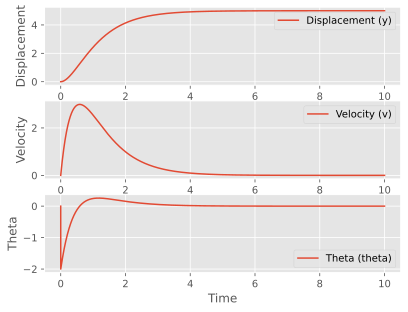

In [551]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt


# Define the ODE system
def ode_system(t, x, theta):
    a = acceleration(theta)  # Get the acceleration at time t
    dxdt = x[1]  # Velocity: dx/dt = v
    dvdt = a      # Acceleration: dv/dt = a
    return [dxdt, dvdt]

# Define the acceleration function
def acceleration(theta):
    return (-5*g/7) * theta # Example acceleration: a = -2t

def pid_controller(theta, y, v, setpoint): # y is the current position, v is the current velocity, theta is the current angle, setpoint is the position we want to reach
    global error_integral
    global error_previous
    global dt
    
    kp = -0.4 # Proportional error to move the system to the setpoint
    ki = 0 # No need for inertegral error since the system has no steady state error
    kd = -0.5 # Derivative error to dampen the oscillations
    
    error = setpoint - y # Calculate the error
    error_integral = error_integral + error*dt # Update the error integral
    error_derivative = -v #(error - error_previous)/dt # Calculate the error derivative
    # error_derivative = (error - error_previous)/dt # Calculate the error derivative
    # print(abs(error_derivative + v))
    error_previous = error # Update the error for the next iteration
    return (kp*error + ki*error_integral + kd*error_derivative) # Output is the theta value to be used in the acceleration function


# Set up the ODE solver
solver = ode(ode_system)
solver.set_initial_value(y=[0, 0], t=0)  # Initial conditions: y(0) = 0, v(0) = 0
solver.set_f_params(0)  # Set the parameter theta to 0

# Set up the time points to evaluate the solution
t_start = 0
t_end = 10
dt = 0.001
theta0 = 0 
t_values = [t_start]
y_values = [solver.y[0]]
v_values = [solver.y[1]]
theta_values = [theta0]

g = 9.81  # Acceleration due to gravity (m/s^2)

error_integral = 0 # Initialize the integral of the error
error_previous = 0 # Initialize the previous error


# Solve the ODE system using a while loop
while solver.successful() and solver.t < t_end:
    # Get theta from PID
    theta_t = pid_controller(theta0, solver.y[0], solver.y[1], setpoint=5)  #pass in current theta, y, v, and dt
    theta_values.append(theta_t)
    solver.set_f_params(theta_t)  # Set the parameter theta to the new value
    
    # Solve for the next value
    solver.integrate(t=solver.t + dt)
    
    # Store the solution for plotting
    t_values.append(solver.t)
    y_values.append(solver.y[0])
    v_values.append(solver.y[1])
    

# Convert the lists to numpy arrays
t_values = np.array(t_values)
y_values = np.array(y_values)
v_values = np.array(v_values)
tg_values = np.array(theta_values)

# Plot the results
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t_values, y_values, label='Displacement (y)')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_values, v_values, label='Velocity (v)')
plt.xlabel('Time')
plt.ylabel('Velocity') 
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_values, tg_values, label='Theta (theta)')
plt.xlabel('Time')
plt.ylabel('Theta')
plt.legend()

plt.show()